In [1]:
import matplotlib.pyplot as plt

from fitting import create_ensemble, load_data, create_datasets
import torch


labels = ["x (mm)", r"$p_x$ (mrad)","y (mm)",r"$p_y$ (mrad)","z (mm)",r"$p_z$ (mrad)"]

tkwargs = {"dtype": torch.float}
save_dir = "double_small_emittance_case_cov_term_no_energy_spread/"
quad_strengths, image_data, bins, xx,_ = load_data()
train_dset = torch.load(save_dir + "/train.dset")
test_dset = torch.load(save_dir + "/test.dset")

bin_width = bins[1] - bins[0]
bandwidth = bin_width / 2


ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)

n_particles = 100000
for ele in ensemble:
    ele.beam.set_base_beam(
        ele.beam.base_dist,
        n_particles,
        p0c=torch.tensor(10.0e6)
    )

ensemble.cuda();

/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
from phase_space_reconstruction.utils import calculate_ellipse
# calculate rms stats from each image
covs = []
for ele in image_data.transpose(-1,-2):
    centroid, cov = calculate_ellipse(ele, bins, bins)
    covs += [cov]

covs = torch.stack(covs)

# plot reconstruction covs
with torch.no_grad():
    predictions = []
    for i in range(20):
        p, _, _ = ensemble[i](quad_strengths[:,0,:].cuda())
        predictions += [p]

predictions = torch.stack(predictions).cpu().transpose(0,1)
rcovs = []
for ele in predictions.transpose(-1,-2):
    centroid, cov = calculate_ellipse(ele, bins, bins)
    rcovs += [cov]

rcovs = torch.stack(rcovs)
rcovs_mean = rcovs.mean(dim=1)
rcovs_std = rcovs.std(dim=1)


<ErrorbarContainer object of 3 artists>

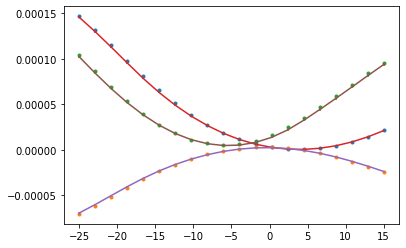

In [3]:
plt.plot(quad_strengths.detach().cpu().flatten(), covs[...,0,0].detach().cpu().flatten(),".")
plt.plot(quad_strengths.detach().cpu().flatten(), covs[...,1,0].detach().cpu().flatten(),".")
plt.plot(quad_strengths.detach().cpu().flatten(), covs[...,1,1].detach().cpu().flatten(),".")

plt.errorbar(quad_strengths[:,0,:].detach().cpu().flatten(), rcovs_mean[...,0,0]
             .flatten(), rcovs_std[...,0,0].flatten())
plt.errorbar(quad_strengths[:,0,:].detach().cpu().flatten(), rcovs_mean[...,1,0]
             .flatten(), rcovs_std[...,1,0].flatten())
plt.errorbar(quad_strengths[:,0,:].detach().cpu().flatten(), rcovs_mean[...,1,1]
             .flatten(), rcovs_std[...,1,1].flatten())
#plt.plot(quad_strengths[:,0,:].detach().cpu().flatten(), rcovs[...,1,0].flatten(),"+")
#plt.plot(quad_strengths[:,0,:].detach().cpu().flatten(), rcovs[...,1,1].flatten(),"+")


tensor(357.4030, grad_fn=<MeanBackward0>)
tensor(1.4906, grad_fn=<MeanBackward0>)
tensor(1.2084, grad_fn=<MeanBackward0>)
tensor(1.1581, grad_fn=<MeanBackward0>)
tensor(1.1618, grad_fn=<MeanBackward0>)
tensor(1.1696, grad_fn=<MeanBackward0>)
tensor(1.1633, grad_fn=<MeanBackward0>)
tensor(1.1555, grad_fn=<MeanBackward0>)
tensor(1.1596, grad_fn=<MeanBackward0>)
tensor(1.1679, grad_fn=<MeanBackward0>)
tensor(1.1648, grad_fn=<MeanBackward0>)
tensor(1.1586, grad_fn=<MeanBackward0>)
tensor(1.1577, grad_fn=<MeanBackward0>)
tensor(1.1964, grad_fn=<MeanBackward0>)
tensor(1.2173, grad_fn=<MeanBackward0>)
tensor(1.1480, grad_fn=<MeanBackward0>)
tensor(1.1851, grad_fn=<MeanBackward0>)
tensor(1.1477, grad_fn=<MeanBackward0>)
tensor(1.2035, grad_fn=<MeanBackward0>)
tensor(1.1507, grad_fn=<MeanBackward0>)
tensor(2.1248e-06, grad_fn=<MulBackward0>)
tensor(356.1988, grad_fn=<MeanBackward0>)
tensor(2.5528, grad_fn=<MeanBackward0>)
tensor(2.5521, grad_fn=<MeanBackward0>)
tensor(2.5637, grad_fn=<MeanBackw

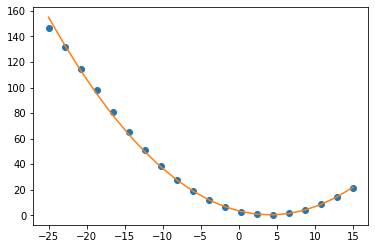

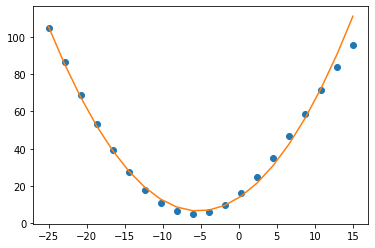

In [4]:
from phase_space_reconstruction.modeling import NormalizedQuadScan
from torch.nn.functional import mse_loss


# fit phase spaces
train_s11 = covs.squeeze()[:,0,0].detach().cpu()
train_s22 = covs.squeeze()[:,1,1].detach().cpu()

for ele in [train_s11, train_s22]:
    train_k = quad_strengths.flatten().cpu()
    quad_length = torch.tensor(0.1)
    drift = torch.tensor(1.0)
    A = train_s11.max().sqrt()

    model = NormalizedQuadScan(A, drift, quad_length)

    optimizer = torch.optim.Adam(
            model.parameters(), lr=0.01
    )

    if 1:
        for i in range(20000):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(train_k)
            # Calc loss and backprop gradients
            loss = torch.abs(output*1e6 - ele*1e6).mean()
            loss.backward()
            if not i % 1000:
                print(loss)
            optimizer.step()

        #print(list(model.named_parameters()))

    with torch.no_grad():
        #model.beam_matrix = torch.tensor(((s11, s12), (s12, s22)))
        #print(list(model.named_parameters()))

        pred_y = model(train_k)
        plt.figure()
        plt.plot(train_k, ele*1e6, "o")
        plt.plot(train_k, pred_y.detach()*1e6)
    print(model.emittance())


In [5]:
covs.flatten().shape

torch.Size([80])